In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import time

In [5]:
from models import FFNN

In [6]:
print("Downloading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.astype(float)
y = y.astype(int)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
X = X / 255.0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

In [11]:
input_size = 784  # images 28x28 = 784 pixels
hidden_sizes = [64] 
output_size = 10  # digits 0-9

In [12]:
ffnn_model = FFNN(
    layer_sizes=[input_size] + hidden_sizes + [output_size],
    activations=['relu'] * len(hidden_sizes) + ['softmax'],
    loss='categorical_cross_entropy',
    weight_init='he'
)

In [13]:
sklearn_model = MLPClassifier(
    hidden_layer_sizes=hidden_sizes,
    activation='relu',
    solver='sgd', 
    learning_rate_init=0.01,
    max_iter=10,
    random_state=42
)

In [14]:
print("\nTraining custom FFNN model...")
start_time = time.time()
ffnn_history = ffnn_model.train(
    X_train, y_train_one_hot,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    verbose=1
)
ffnn_training_time = time.time() - start_time
print(f"Custom FFNN training time: {ffnn_training_time:.2f} seconds")


Training custom FFNN model...
Epoch 1/10, Train Loss: 0.6886
Epoch 2/10, Train Loss: 0.3431
Epoch 3/10, Train Loss: 0.2933
Epoch 4/10, Train Loss: 0.2641
Epoch 5/10, Train Loss: 0.2426
Epoch 6/10, Train Loss: 0.2255
Epoch 7/10, Train Loss: 0.2110
Epoch 8/10, Train Loss: 0.1985
Epoch 9/10, Train Loss: 0.1879
Epoch 10/10, Train Loss: 0.1785
Custom FFNN training time: 11.81 seconds


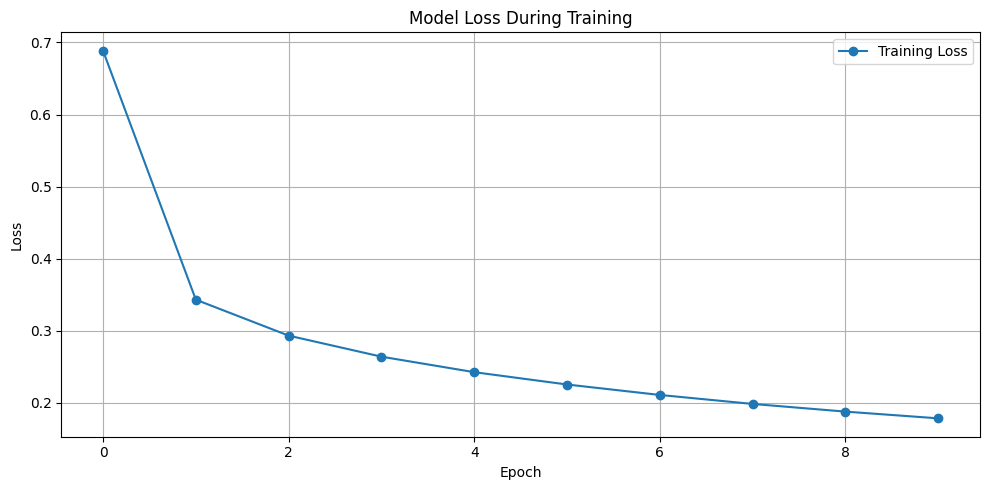

{'train_loss': [0.6885635325151341,
  0.34314902105760264,
  0.29329057399668496,
  0.2640990995001348,
  0.24259317009027664,
  0.22548848648290745,
  0.21097325442831855,
  0.19852299410031296,
  0.18786711571450776,
  0.17853964618990315],
 'val_loss': []}

In [15]:
ffnn_model.plot_loss(ffnn_history)

In [16]:
ffnn_predictions = ffnn_model.predict(X_test)
ffnn_pred_classes = np.argmax(ffnn_predictions, axis=1)
ffnn_accuracy = accuracy_score(y_test, ffnn_pred_classes)
ffnn_accuracy

0.9477857142857142

In [17]:
print("\nTraining sklearn MLPClassifier...")
start_time = time.time()
sklearn_model.fit(X_train, y_train)
sklearn_training_time = time.time() - start_time
print(f"sklearn MLPClassifier training time: {sklearn_training_time:.2f} seconds")


Training sklearn MLPClassifier...
sklearn MLPClassifier training time: 6.71 seconds


c:\Users\Randy Verdian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
sklearn_accuracy

0.9530714285714286

### Coba coba dataset lain

In [19]:
import pandas as pd
df = pd.read_csv('./data-coba-coba/dataset1.csv', index_col='id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [20]:
# KNNeighbour
from sklearn.neighbors import KNeighborsRegressor


def knn_imputer(df, target_feat):
  df= df.copy()

  numeric_df= df.select_dtypes(include=[np.number])
  non_empty_feature= numeric_df.loc[:, numeric_df.isna().sum() == 0].columns

  X_train= numeric_df.loc[numeric_df[target_feat].isna() == False, non_empty_feature]
  y_train= numeric_df.loc[numeric_df[target_feat].isna() == False, target_feat]
  X_test= numeric_df.loc[numeric_df[target_feat].isna() == True, non_empty_feature]

  knn = KNeighborsRegressor()
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  df.loc[df[target_feat].isna() == True, target_feat] = y_pred

  return df

target_feat = [col for col in df.columns if df[col].isnull().sum()!=0]

for col in target_feat:
    df = knn_imputer(df, col)

In [21]:
cat_df = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_df = ['age', 'avg_glucose_level', 'bmi']

In [22]:
# Apply log transformation
df['avg_glucose_level']= np.log(df['avg_glucose_level'])
df['bmi']= np.log(df['bmi'])

In [23]:
# Drop the row with Other for gender since it's just a single instance
df = df[df['gender'] != 'Other']

# Convert categorical variables to numerical format using one hot encoding
df= pd.get_dummies(df, columns= cat_df)
for feat in df.columns:
  if df[feat].dtype == 'bool':
    df[feat]= df[feat].astype('int')

In [24]:
# Split the data into X and y
X= df.drop('stroke', axis=1)
y= df['stroke']

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 9046 to 44679
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   avg_glucose_level               5109 non-null   float64
 2   bmi                             5109 non-null   float64
 3   gender_Female                   5109 non-null   int32  
 4   gender_Male                     5109 non-null   int32  
 5   hypertension_0                  5109 non-null   int32  
 6   hypertension_1                  5109 non-null   int32  
 7   heart_disease_0                 5109 non-null   int32  
 8   heart_disease_1                 5109 non-null   int32  
 9   ever_married_No                 5109 non-null   int32  
 10  ever_married_Yes                5109 non-null   int32  
 11  work_type_Govt_job              5109 non-null   int32  
 12  work_type_Never_worked          510

In [25]:
X= X.to_numpy()
y= y.to_numpy()

In [26]:
X_train,X_test,y_train,y_test= train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)

In [27]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [28]:
ffnn_model = FFNN(
    layer_sizes= [22] + [64, 32] + [1],
    activations=['relu'] * 2 + ['sigmoid'],
    loss='binary_cross_entropy',
    weight_init='he'
)

In [29]:
ffnn_history = ffnn_model.train(
    X_train, y_train,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    verbose=1
)

Epoch 1/10, Train Loss: 1.7006
Epoch 2/10, Train Loss: 1.6517
Epoch 3/10, Train Loss: 1.6516
Epoch 4/10, Train Loss: 1.6515
Epoch 5/10, Train Loss: 1.6514
Epoch 6/10, Train Loss: 1.6513
Epoch 7/10, Train Loss: 1.6512
Epoch 8/10, Train Loss: 1.6511
Epoch 9/10, Train Loss: 1.6511
Epoch 10/10, Train Loss: 1.6510


In [30]:
ffnn_predictions = ffnn_model.predict(X_test)
ffnn_pred_classes = np.argmax(ffnn_predictions, axis=1)
ffnn_accuracy = accuracy_score(y_test, ffnn_pred_classes)
ffnn_accuracy

0.9452054794520548